# Classification on CIFAR 10 Dataset

Instructions - 
1. In order to kick start, code for setting up the dataframes has already been given (Step 1 to 5)
2. Go through the entire code written below and put the relavent comment for each line of code. Understanding below mentioned code is very important.
3. After commenting the code in step 1 to 5, complete step 6 and 7

### Step - 1 (Setup Code)

In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
import matplotlib.pyplot as plt
import os


from __future__ import print_function

from builtins import range
from six.moves import cPickle as pickle
from imageio import imread
import platform

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [14]:
from sklearn.metrics import classification_report

In [17]:
from sklearn.model_selection import GridSearchCV

In [2]:
import warnings
warnings.filterwarnings("ignore")

### Step - 2 (Download the dataset)

In [3]:
# # Use this code to download the dataset for the first time
# # You will be required to install wget using pip
# # For Linux users checkout the alternative for 'del'
!pip install wget

# !tar -xzvf cifar-10-python.tar.gz
# !del cifar-10-python.tar.gz

In [4]:
!wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz -O cifar-10-python.tar.gz
!tar -xzvf cifar-10-python.tar.gz

--2021-11-26 22:48:16--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: 'cifar-10-python.tar.gz'

     0K .......... .......... .......... .......... ..........  0%  695K 3m59s
    50K .......... .......... .......... .......... ..........  0% 9.36M 2m8s
   100K .......... .......... .......... .......... ..........  0% 8.96M 92s
   150K .......... .......... .......... .......... ..........  0% 11.9M 72s
   200K .......... .......... .......... .......... ..........  0% 5.10M 64s
   250K .......... .......... .......... .......... ..........  0% 6.03M 58s
   300K .......... .......... .......... .......... ..........  0% 12.5M 51s
   350K .......... .......... .......... .......... ..........  0% 4.14M 50s
   400K .......... .

In [15]:
!wget --help

GNU Wget 1.21.2, a non-interactive network retriever.
Usage: wget [OPTION]... [URL]...

Mandatory arguments to long options are mandatory for short options too.

Startup:
  -V,  --version                   display the version of Wget and exit
  -h,  --help                      print this help
  -b,  --background                go to background after startup
  -e,  --execute=COMMAND           execute a `.wgetrc'-style command

Logging and input file:
  -o,  --output-file=FILE          log messages to FILE
  -a,  --append-output=FILE        append messages to FILE
  -d,  --debug                     print lots of debugging information
  -q,  --quiet                     quiet (no output)
  -v,  --verbose                   be verbose (this is the default)
  -nv, --no-verbose                turn off verboseness, without being quiet
       --report-speed=TYPE         output bandwidth as TYPE.  TYPE can be bits
  -i,  --input-file=FILE           download URLs found in local or external FILE
  

In [2]:
import os
os.getcwd()

'C:\\Users\\manoj'

### Step - 3 (Load the Dataset)

In [5]:
# This cell loads the training and testing dataset. Please note the variables at
# the end of the cell as you would require them to access the train/test data 
# and labels throughout the assignment
def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))


def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = load_pickle(f)
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
        Y = np.array(Y)
        return X, Y


def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte


cifar10_dir = 'cifar-10-batches-py'
#cifar10_dir = r'C:\\Users\\manoj\\cifar-10-python\\cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times
try:
    del X_train, y_train
    del X_test, y_test
    print('Clear previously loaded data.')
except:
    pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


### Step - 4 (Visualization)

Next we visualize the CIFAR-10 dataset. Although these functions are being written for you, we highly recommend you go through the code and make yourself familiar as these are things you will be required to do very often when working on AI/ML projects

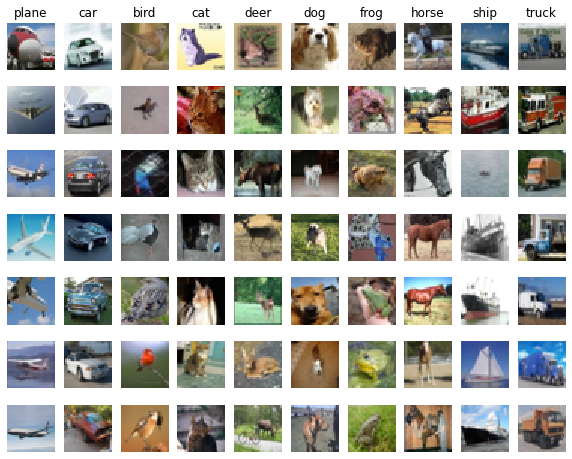

In [6]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

### Step - 5 (Flattening the images)

In the next cell we flatten each image into a single dimensional vector so that it is easy to process. You should be able to reason about the dimensions comfortable.

In [12]:

# Step 5 - Flatten the Images

# Subsample the data for more efficient code execution in this exercise

try:
    del X_train, y_train, X_val
    del X_test, y_test,y_val
    print('Clear previously loaded data.')
except:
    pass
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

num_training=15000
val=1000
mask = range(num_training, num_training + val)
X_val = X_train[mask]
y_val = y_train[(mask)]
y_val = np.ravel(y_val)

mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]
y_train = np.ravel(y_train)

num_test = 5000
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]
y_test = np.ravel(y_test)


# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))

print('X_train and X_test shapes: ',X_train.shape, X_test.shape)
print('y_train and y_test shapes: ',y_train.shape, y_test.shape)
print('X_val and y_val shapes: ' ,X_val.shape, y_val.shape)

X_train and X_test shapes:  (15000, 3072) (5000, 3072)
y_train and y_test shapes:  (15000,) (5000,)
X_val and y_val shapes:  (1000, 3072) (1000,)


### Step - 6 (Apply all possible classification algorithms)

For each algo complete the following steps with appropriate plots, diagrams and code - 
1. Discuss the intuition behind each algorithm
2. Mention pros and cons
3. Discuss about Model parameters and Hyperparameters
4. Discuss about overfitting and underfitting with relavant plots and code (Hint: Use cross validation and plot hyperparameter vs accuracy score)
5. Discuss about train and test time/space complexities
6. Measure the performance of model using various metrics and write in detail about each metric

# KNN Algorithm

The K-NN working can be explained on the basis of the below algorithm:

Step-1: Select the number K nearest neighborhood.

Step-2: Calculate the Euclidean distance of K number of neighbors to the given datapoint.

Step-3: Take the K nearest neighbors as per the calculated Euclidean distance to the given point.

Step-4: Among these k neighbors, count the number of the data points in each category.

Step-5: Assign the new data points to that category for which the number of the neighbor is maximum.

**Pro**
It is simple to implement. It is robust to the noisy training data.

**Cons**
The computation cost is expensive, because of calculating the distance between the data points for all the training samples. It is lazy algorithm as it doesnt learn from the training data and instead it stores the dataset.

In [15]:
# Implementing the K-Neighbors Classifier

from sklearn.neighbors import KNeighborsClassifier
import time
# Getting k from the user
k = int(input("Enter the value of k for k-Nearest Neighbor Classifier: "))
knn = KNeighborsClassifier(n_neighbors=k)   

tic = time.time()
knn.fit(X_train, y_train)
toc = time.time()
duration=toc-tic
print('Training duration is: ',duration)

start=time.time()
y_val_predict= knn.predict(X_val)
completed=time.time()
duration2=completed-start
print('Validation duration is:',duration2)

print("K- Neighbors Prediction")
print(classification_report(y_val, y_val_predict))

Enter the value of k for k-Nearest Neighbor Classifier: 3
Training duration is:  0.11808490753173828
Validation duration is: 2.0167829990386963
K- Neighbors Prediction
              precision    recall  f1-score   support

           0       0.26      0.55      0.36        89
           1       0.36      0.12      0.18       103
           2       0.20      0.51      0.29       106
           3       0.22      0.18      0.19       108
           4       0.21      0.36      0.26       103
           5       0.53      0.17      0.26        93
           6       0.25      0.17      0.20       111
           7       0.59      0.10      0.17       102
           8       0.37      0.45      0.40        91
           9       0.40      0.06      0.11        94

    accuracy                           0.26      1000
   macro avg       0.34      0.27      0.24      1000
weighted avg       0.34      0.26      0.24      1000



Accuracy is 26%

Classification Report

**Precision** is defined as the ratio of true positives to the sum of true and false positives.

**Recall** is defined as the ratio of true positives to the sum of true positives and false negatives.

**F1_score** is the weighted harmonic mean of precision and recall.

**Support** is the number of actual occurrences of the class in the dataset.

# SVM Algorithm

SVM algorithm helps to find the best line or decision boundary; this best boundary or region is called as a hyperplane.The distance between the vectors and the hyperplane is called as margin. And the goal of SVM is to maximize this margin.

**Pros**
It works really well with a clear margin of separation.

**Cons**
It also doesn’t perform very well, when the data set has more noise

In [ ]:
# Implementing the Support Vector Classifier

from sklearn.svm import SVC
import time

clf = SVC()  

tic = time.time()
clf.fit(X_train, y_train)
toc = time.time()
duration=toc-tic
print('Training duration is: ',duration)

start=time.time()
y_val_predict= clf.predict(X_val)
completed=time.time()
duration2=completed-start
print('Validation duration is:',duration2)

print("SVC Prediction")
print(classification_report(y_val, y_val_predict))